# Motivation

This NB focuses on analysing the effects of the sigmoid function over the norm3 weight modifier functions. 

There are two different sets of experiments, one generated from the non-tumour dataset the other from the tumour dataset. For each 3 networks were generated: standard, norm3 and sigmoid

In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio
import multiprocess as mp

sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities.helpers import save_fig
from NetworkAnalysis.utilities.helpers import save_fig
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
import NetworkAnalysis.utilities.clustering as cs
from NetworkAnalysis.NetworkComp import NetworkComp


pio.templates.default = "ggplot2"

pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/network_II"

figures_path = "../network_ii/validation/"

# Exps path
base_sbm_path = "../../../iNet_v2/"
t_exps = "modifiers_v3_t/"
h_exps = "modifiers_v3_h/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

all_tum_tpms = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")


healthy_metadata = pd.read_csv(f"{data_base}/metadata/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample", dtype_backend="pyarrow")

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Load experiments

In [3]:
tum = ExperimentSet("tum", base_path, t_exps, tcga_mutations_df, sel_sets = ["5K"], rel_path="../", exp_type='iNet')

%autoreload 2

exps = {}
for idx, exp in enumerate(tum.get_exps()):
    print(f"Loading Graph-Tool for {exp.type}")
    exp = GtExp.from_pgcna_inet(exp, rel_path="")

    # partitions from hSBM
    exp.hsbm_add_vp(mut_df=tcga_mutations_df)
    com_df, _ = exp.hsbm_get_gt_df()

    # export to gephi
    exp.export_to_gephi(save=False, com_df=com_df)

    # Need it for comparison
    exps[exp.type] = exp

tum.exps = exps

##### Experiment labels:  dict_keys(['sigmoid_5K_6TF_hsbm', 'norm3_5K_6TF_hsbm', 'standard_5K_6TF_hsbm'])
Loading Graph-Tool for sigmoid_5K_6TF_hsbm
Loading Graph-Tool for norm3_5K_6TF_hsbm
Loading Graph-Tool for standard_5K_6TF_hsbm


In [4]:
healthy = ExperimentSet("h", base_path, h_exps, tcga_mutations_df, sel_sets = ["5K"], rel_path="../", exp_type='iNet')

%autoreload 2

exps = {}
for idx, exp in enumerate(healthy.get_exps()):
    print(f"Loading Graph-Tool for {exp.type}")
    exp = GtExp.from_pgcna_inet(exp, rel_path="")

    # partitions from hSBM
    exp.hsbm_add_vp(mut_df=tcga_mutations_df)
    com_df, _ = exp.hsbm_get_gt_df()

    # export to gephi
    exp.export_to_gephi(save=False, com_df=com_df)

    # Need it for comparison
    exps[exp.type] = exp

healthy.exps = exps

##### Experiment labels:  dict_keys(['norm3_5K_6TF_hsbm', 'standard_5K_6TF_hsbm', 'sigmoid_5K_6TF_hsbm'])
Loading Graph-Tool for norm3_5K_6TF_hsbm
Loading Graph-Tool for standard_5K_6TF_hsbm
Loading Graph-Tool for sigmoid_5K_6TF_hsbm


In [5]:
for exp in healthy.get_exps():
    com_df, _ = exp.hsbm_get_gt_df()
    exp.com_df = com_df
    exp.get_ModCon(com_df=com_df)

for exp in tum.get_exps():
    com_df, _ = exp.hsbm_get_gt_df()
    exp.com_df = com_df
    exp.get_ModCon(com_df=com_df)

# Analysis

In [6]:
def get_sel_genes(exp_set: ExperimentSet, tum_tpms: pd.DataFrame, mut_df: pd.DataFrame, tf_list: list):
    all_df = []
    num_genes = 100
    for exp in exp_set.get_exps():
        sort_col = "ModCon_{}_gt".format(exp.type)
        mevsMut, info = exp.get_iMevs(h_tpms=exp.tpm_df, tum_tpms=tum_tpms, modCon=exp.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True)

        # Export to gephi to add ModConRank
        exp.export_to_gephi(save=False, com_df=exp.com_df)

        dmy_df = pd.DataFrame()
        modifier = exp.type.split("_")[0]
        for com, val in info.items():
            dmy = pd.DataFrame(index=val["modCon_genes"], columns=["modifier"])
            # dmy["com"] = com
            dmy_df = pd.concat([dmy_df, dmy], axis=0)

        dmy_df["modifier"] = modifier
        all_df.append(dmy_df)

    all_df = pd.concat(all_df, axis=0)

    all_df["mut_count"] = mut_df["count"]
    all_df.loc[all_df.index.isin(tf_list), "TF"] = 1
    all_df.fillna(0, inplace=True)
    all_df = all_df.reset_index(names="gene")

    return all_df


df_h = get_sel_genes(exp_set=healthy, tum_tpms=all_tum_tpms, mut_df=tcga_mutations_df, tf_list=tf_list)
df_t = get_sel_genes(exp_set=tum, tum_tpms=all_tum_tpms, mut_df=tcga_mutations_df, tf_list=tf_list)

In [7]:
if 0:
    tst_df = df_h[df_h["mut_count"] > 0]
    fig = px.violin(
        tst_df, y="mut_count", x="modifier", color="modifier", log_y=False, points="all", hover_data=["gene"], title="Mut Count - Non-tum", box=True, height=700
    )
    display(fig)
    fig = px.histogram(tst_df, x="mut_count", color="modifier", log_y=True, title="Mut Count - Non-tum")
    fig.show()

In [8]:
if 0:
    tst_df = df_t[df_t["mut_count"] > 0]
    fig = px.violin(
        tst_df, y="mut_count", x="modifier", color="modifier", log_y=False, points="all", hover_data=["gene"], title="Mut Count - Tum", box=True, height=700
    )
    display(fig)
    fig = px.histogram(tst_df, x="mut_count", color="modifier", log_y=True, title="Mut count - Tum")
    fig.show()

## ModCon Rank

In [9]:
def get_modConRank(exp_set: ExperimentSet, mut_df: pd.DataFrame, tf_list: list):
    all_df = []
    for exp in exp_set.get_exps():
        sort_col = f"ModCon_{exp.type}_gt"
        modifier = exp.type.split("_")[0]

        dmy_df = pd.DataFrame()
        for com, val in exp.gt_modCon.items():
            tst = pd.DataFrame(val[sort_col].rank(ascending=False))
            tst["norm"] = (tst - tst.min()) / (tst.max() - tst.min())

            dmy_df = pd.concat([dmy_df, tst], axis=0)
            # Not sure why it didn't work to concatenate in the above line
            dmy_df.loc[dmy_df.index.isin(val.index), "ModCon"] = val[sort_col]

        dmy_df.rename(columns={sort_col: "ModCon_Rank"}, inplace=True)

        dmy_df["type"] = modifier
        all_df.append(dmy_df)

    all_df = pd.concat(all_df, axis=0)

    all_df["mut_count"] = mut_df["count"]
    all_df.loc[all_df.index.isin(tf_list), "TF"] = 1
    all_df.fillna(0, inplace=True)
    all_df = all_df.reset_index(names="gene")

    all_df["type"] = all_df["type"].replace({"sigmoid": "Reward v2", "norm3": "Reward v1", "standard": "Standard"})

    return all_df


df_rank_h = get_modConRank(exp_set=healthy, mut_df=tcga_mutations_df, tf_list=tf_list)
df_rank_t = get_modConRank(exp_set=tum, mut_df=tcga_mutations_df, tf_list=tf_list)

In [10]:
tst = df_rank_h.copy(deep=True)
tst = tst[tst["ModCon_Rank"] <= 100]
colors = px.colors.qualitative.D3
color_map = {"Standard": colors[0], "Reward v1": colors[1], "Reward v2": colors[2]}
tst.sort_values(by="mut_count", inplace=True)
fig = px.histogram(
    tst,
    y="mut_count",
    x="ModCon_Rank",
    color="type",
    facet_col="type",
    title="Non-tum networks - ModCon Rank (norm) vs mutation count",
    color_discrete_map=color_map,
    category_orders={"type": color_map.keys()},
)
fig = fig.update_layout(
    title="",
    xaxis=dict(tickfont=dict(size=24), title="ModCon Rank normalised"),
    yaxis=dict(tickfont=dict(size=24), title="Sum of mutation burden"),
    font=dict(size=20),
    showlegend=False,
    height=700,
)
fig.update_annotations(font_size=22)
fig.for_each_xaxis(lambda x: x.update({"title": ""}))
fig.show()
fig.add_annotation(showarrow=False, xanchor="center", xref="paper", x=0.5, yref="paper", y=-0.16, text="ModCon Rank normalised", font_size=20)
save_fig(name="non_tum_modCon_hist_3", fig=fig, base_path=figures_path, width=1500, height=500, margin=0.04)

In [11]:
stats_net = []
for net_type in ["Standard", "Reward v1", "Reward v2"]:
    print(net_type)
    dmy = tst[tst["type"] == net_type]
    dmy = dmy.sort_values(by="ModCon", ascending=False)[:100]
    # brea
    dmy = dmy["mut_count"]
    stats_net.append([net_type, dmy.mean(), dmy.median(), dmy.std(), dmy.var(), dmy.max(), dmy.min(), dmy.shape[0]])

stats_net = pd.DataFrame(stats_net, columns=["type", "mean", "median", "std", "var", "max", "min", "total"]).round(3)
stats_net

Standard
Reward v1
Reward v2


,type,mean,median,std,var,max,min,total
0,Standard,5.46,3.0,7.353,54.069,49.0,0.0,100
1,Reward v1,20.82,16.5,11.956,142.937,80.0,7.0,100
2,Reward v2,23.57,19.0,10.925,119.359,80.0,13.0,100


In [12]:
from scipy import stats

rwd_1 = tst.loc[tst["type"] == "Reward v1"]
rwd_2 = tst.loc[tst["type"] == "Reward v2"]
std = tst.loc[tst["type"] == "Standard"]


metrics = ["mut_count", "ModCon_Rank"]
test_rest = []
for metric in metrics:
    metrics_stats = []
    statistic, p_value = stats.mannwhitneyu(
        rwd_1[metric],
        rwd_2[metric],
    )
    # print(f"{metric}: Rwd 1 vs Rwd 2 {statistic}, p-value: {p_value}")
    metrics_stats.append((statistic, p_value))

    statistic, p_value = stats.mannwhitneyu(
        std[metric],
        rwd_1[metric],
    )
    metrics_stats.append((statistic, p_value))

    statistic, p_value = stats.mannwhitneyu(
        std[metric],
        rwd_2[metric],
    )
    metrics_stats.append((statistic, p_value))

    test_rest.append(metrics_stats)

In [13]:
pd.DataFrame(test_rest, columns=["Reward v1 vs Reward v2", "Standard vs Reward v1", "Standard vs Reward v2"], index=metrics).T

,mut_count,ModCon_Rank
Reward v1 vs Reward v2,"(4752647.0, 3.0310653006221496e-17)","(4418659.0, 0.0016899144706217916)"
Standard vs Reward v1,"(4653638.5, 3.044500793837291e-17)","(5804760.5, 7.07450356517162e-12)"
Standard vs Reward v2,"(3782724.0, 0.3140905130107762)","(4276523.5, 3.789724196763471e-21)"


In [14]:
metric = "mut_count"
statistic, p_value = stats.mannwhitneyu(
    std[metric],
    rwd_2[metric],
)
print(f"{metric} difference,  Mann-Whitney U statistic: {statistic}, p-value: {p_value}")


metric = "ModCon_Rank"
statistic, p_value = stats.mannwhitneyu(
    std[metric],
    rwd_2[metric],
)
print(f"{metric} difference,  Mann-Whitney U statistic: {statistic}, p-value: {p_value}")

mut_count difference,  Mann-Whitney U statistic: 3782724.0, p-value: 0.3140905130107762
ModCon_Rank difference,  Mann-Whitney U statistic: 4276523.5, p-value: 3.789724196763471e-21


In [15]:
metric = "mut_count"
statistic, p_value = stats.mannwhitneyu(
    std[metric],
    rwd_1[metric],
)
print(f"{metric} difference,  Mann-Whitney U statistic: {statistic}, p-value: {p_value}")


metric = "ModCon_Rank"
statistic, p_value = stats.mannwhitneyu(
    std[metric],
    rwd_1[metric],
)
print(f"{metric} difference,  Mann-Whitney U statistic: {statistic}, p-value: {p_value}")

mut_count difference,  Mann-Whitney U statistic: 4653638.5, p-value: 3.044500793837291e-17
ModCon_Rank difference,  Mann-Whitney U statistic: 5804760.5, p-value: 7.07450356517162e-12


## Size imbalance and gene selection

In [16]:
rwd_exp_1: GtExp = healthy.exps["norm3_5K_6TF_hsbm"]
rwd_exp_2: GtExp = healthy.exps["sigmoid_5K_6TF_hsbm"]
std_exp: GtExp = healthy.exps["standard_5K_6TF_hsbm"]

num_genes, sort_col = 100, f"ModCon_{std_exp.type}_gt"
mevs_std, info_std = std_exp.get_iMevs(
    h_tpms=std_exp.tpm_df, tum_tpms=all_tum_tpms, modCon=std_exp.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

num_genes, sort_col = 100, f"ModCon_{rwd_exp_1.type}_gt"
mevs_rwd_1, info_rwd_1 = rwd_exp_1.get_iMevs(
    h_tpms=rwd_exp_1.tpm_df, tum_tpms=all_tum_tpms, modCon=rwd_exp_1.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

num_genes, sort_col = 100, f"ModCon_{rwd_exp_2.type}_gt"
mevs_rwd_2, info_rwd_2 = rwd_exp_2.get_iMevs(
    h_tpms=rwd_exp_2.tpm_df, tum_tpms=all_tum_tpms, modCon=rwd_exp_2.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

genes_included = []
for info in [info_std, info_rwd_1, info_rwd_2]:
    total_genes = 0
    for com, val in info.items():
        total_genes += len(val["modCon_genes"])
    genes_included.append(total_genes)


genes_included_h = pd.DataFrame(genes_included, columns=["Total"], index=["Standard", "Reward v1", "Reward v2"])
genes_included_h["Type"] = "Non tumour"

In [17]:
rwd_exp_1: GtExp = tum.exps["norm3_5K_6TF_hsbm"]
rwd_exp_2: GtExp = tum.exps["sigmoid_5K_6TF_hsbm"]
std_exp: GtExp = tum.exps["standard_5K_6TF_hsbm"]

num_genes, sort_col = 100, f"ModCon_{std_exp.type}_gt"
mevs_std, info_std = std_exp.get_iMevs(
    h_tpms=std_exp.tpm_df, tum_tpms=all_tum_tpms, modCon=std_exp.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

num_genes, sort_col = 100, f"ModCon_{rwd_exp_1.type}_gt"
mevs_rwd_1, info_rwd_1 = rwd_exp_1.get_iMevs(
    h_tpms=rwd_exp_1.tpm_df, tum_tpms=all_tum_tpms, modCon=rwd_exp_1.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

num_genes, sort_col = 100, f"ModCon_{rwd_exp_2.type}_gt"
mevs_rwd_2, info_rwd_2 = rwd_exp_2.get_iMevs(
    h_tpms=rwd_exp_2.tpm_df, tum_tpms=all_tum_tpms, modCon=rwd_exp_2.gt_modCon, sort_col=sort_col, num_genes=num_genes, verbose=True
)

genes_included = []
for info in [info_std, info_rwd_1, info_rwd_2]:
    total_genes = 0
    for com, val in info.items():
        total_genes += len(val["modCon_genes"])
    genes_included.append(total_genes)


genes_included_t = pd.DataFrame(genes_included, columns=["Total"], index=["Standard", "Reward v1", "Reward v2"])
genes_included_t["Type"] = "Tumour"

In [18]:
pd.concat([genes_included_t, genes_included_h])

,Total,Type
Standard,3242,Tumour
Reward v1,4057,Tumour
Reward v2,4400,Tumour
Standard,3056,Non tumour
Reward v1,3459,Non tumour
Reward v2,2438,Non tumour


# Validate

This is used to see if the network metrics that have similar distributions with previous

In [19]:
rwd_exp_1: GtExp = healthy.exps["norm3_5K_6TF_hsbm"]
rwd_exp_2: GtExp = healthy.exps["sigmoid_5K_6TF_hsbm"]
std_exp: GtExp = healthy.exps["standard_5K_6TF_hsbm"]

std_com_df, _ = std_exp.hsbm_get_gt_df()
rwd_1_com_df, _ = rwd_exp_1.hsbm_get_gt_df()
rwd_2_com_df, _ = rwd_exp_2.hsbm_get_gt_df()

# Nodes df
std_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=std_exp.nodes_df, tpm_df=std_exp.tpm_df)
rwd_1_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=rwd_exp_1.nodes_df, tpm_df=rwd_exp_1.tpm_df)
rwd_2_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=rwd_exp_2.nodes_df, tpm_df=rwd_exp_2.tpm_df)

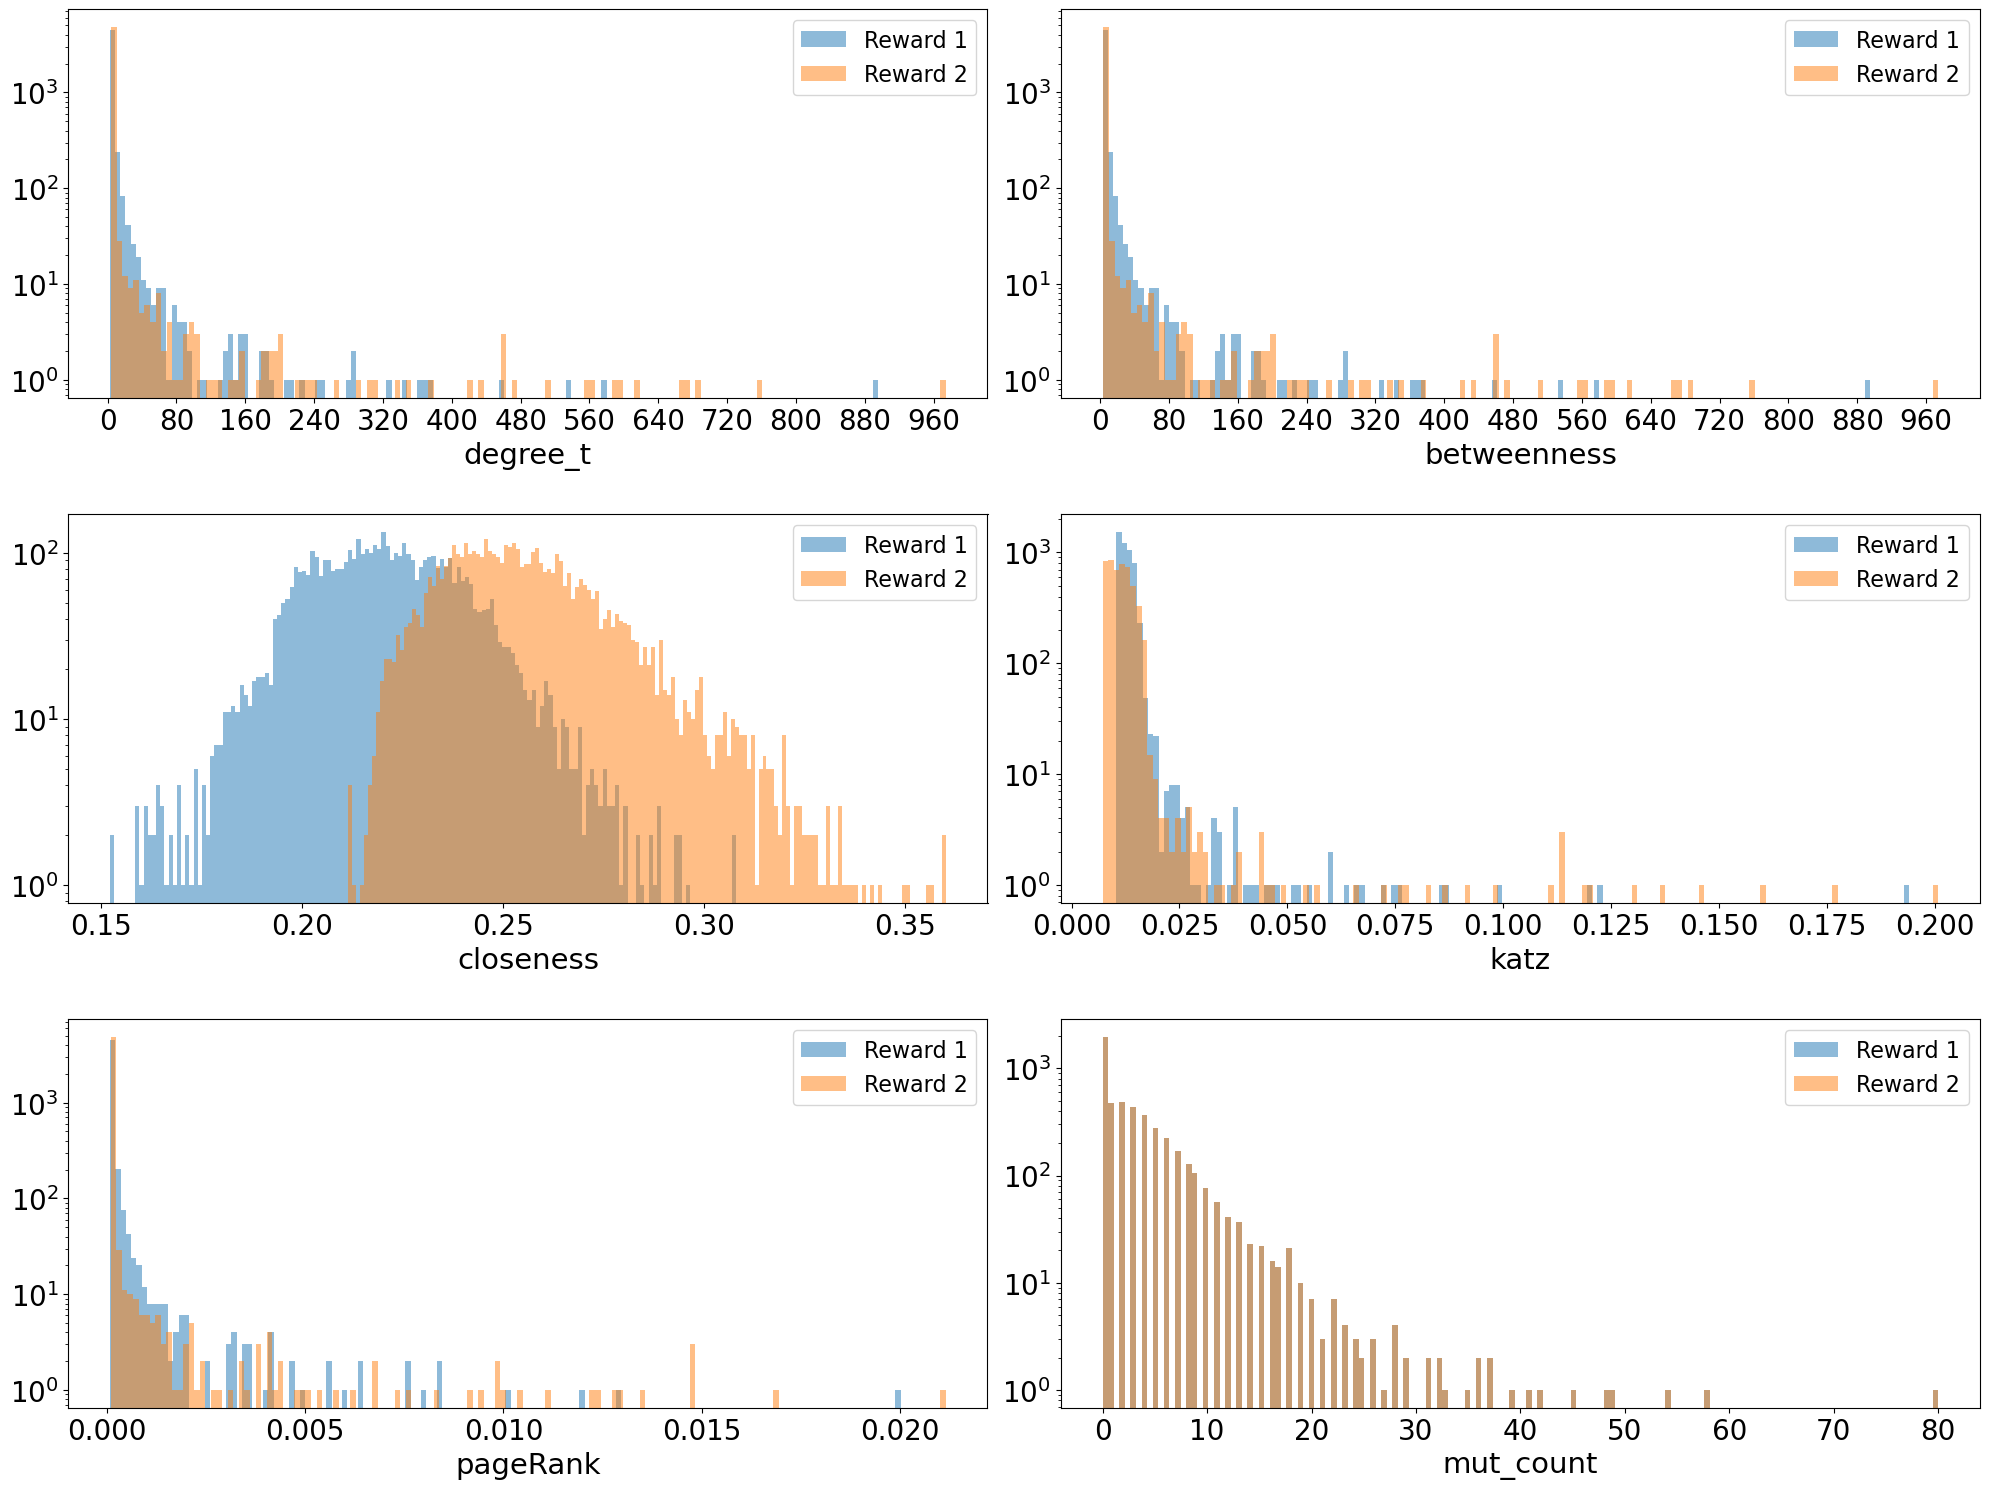

In [20]:
if 1:
    comp_std_net: NetworkComp = NetworkComp(healthy, 5, "norm3_5K_6TF_hsbm", "sigmoid_5K_6TF_hsbm", mod_type="sbm")

    fig, graph_stats_std, graph_stats_rwd = comp_std_net.plot_network_stats(
        nodes_df_1=rwd_1_nodes_df, nodes_df_2=rwd_2_nodes_df, label_1="Reward 1", label_2="Reward 2"
    )

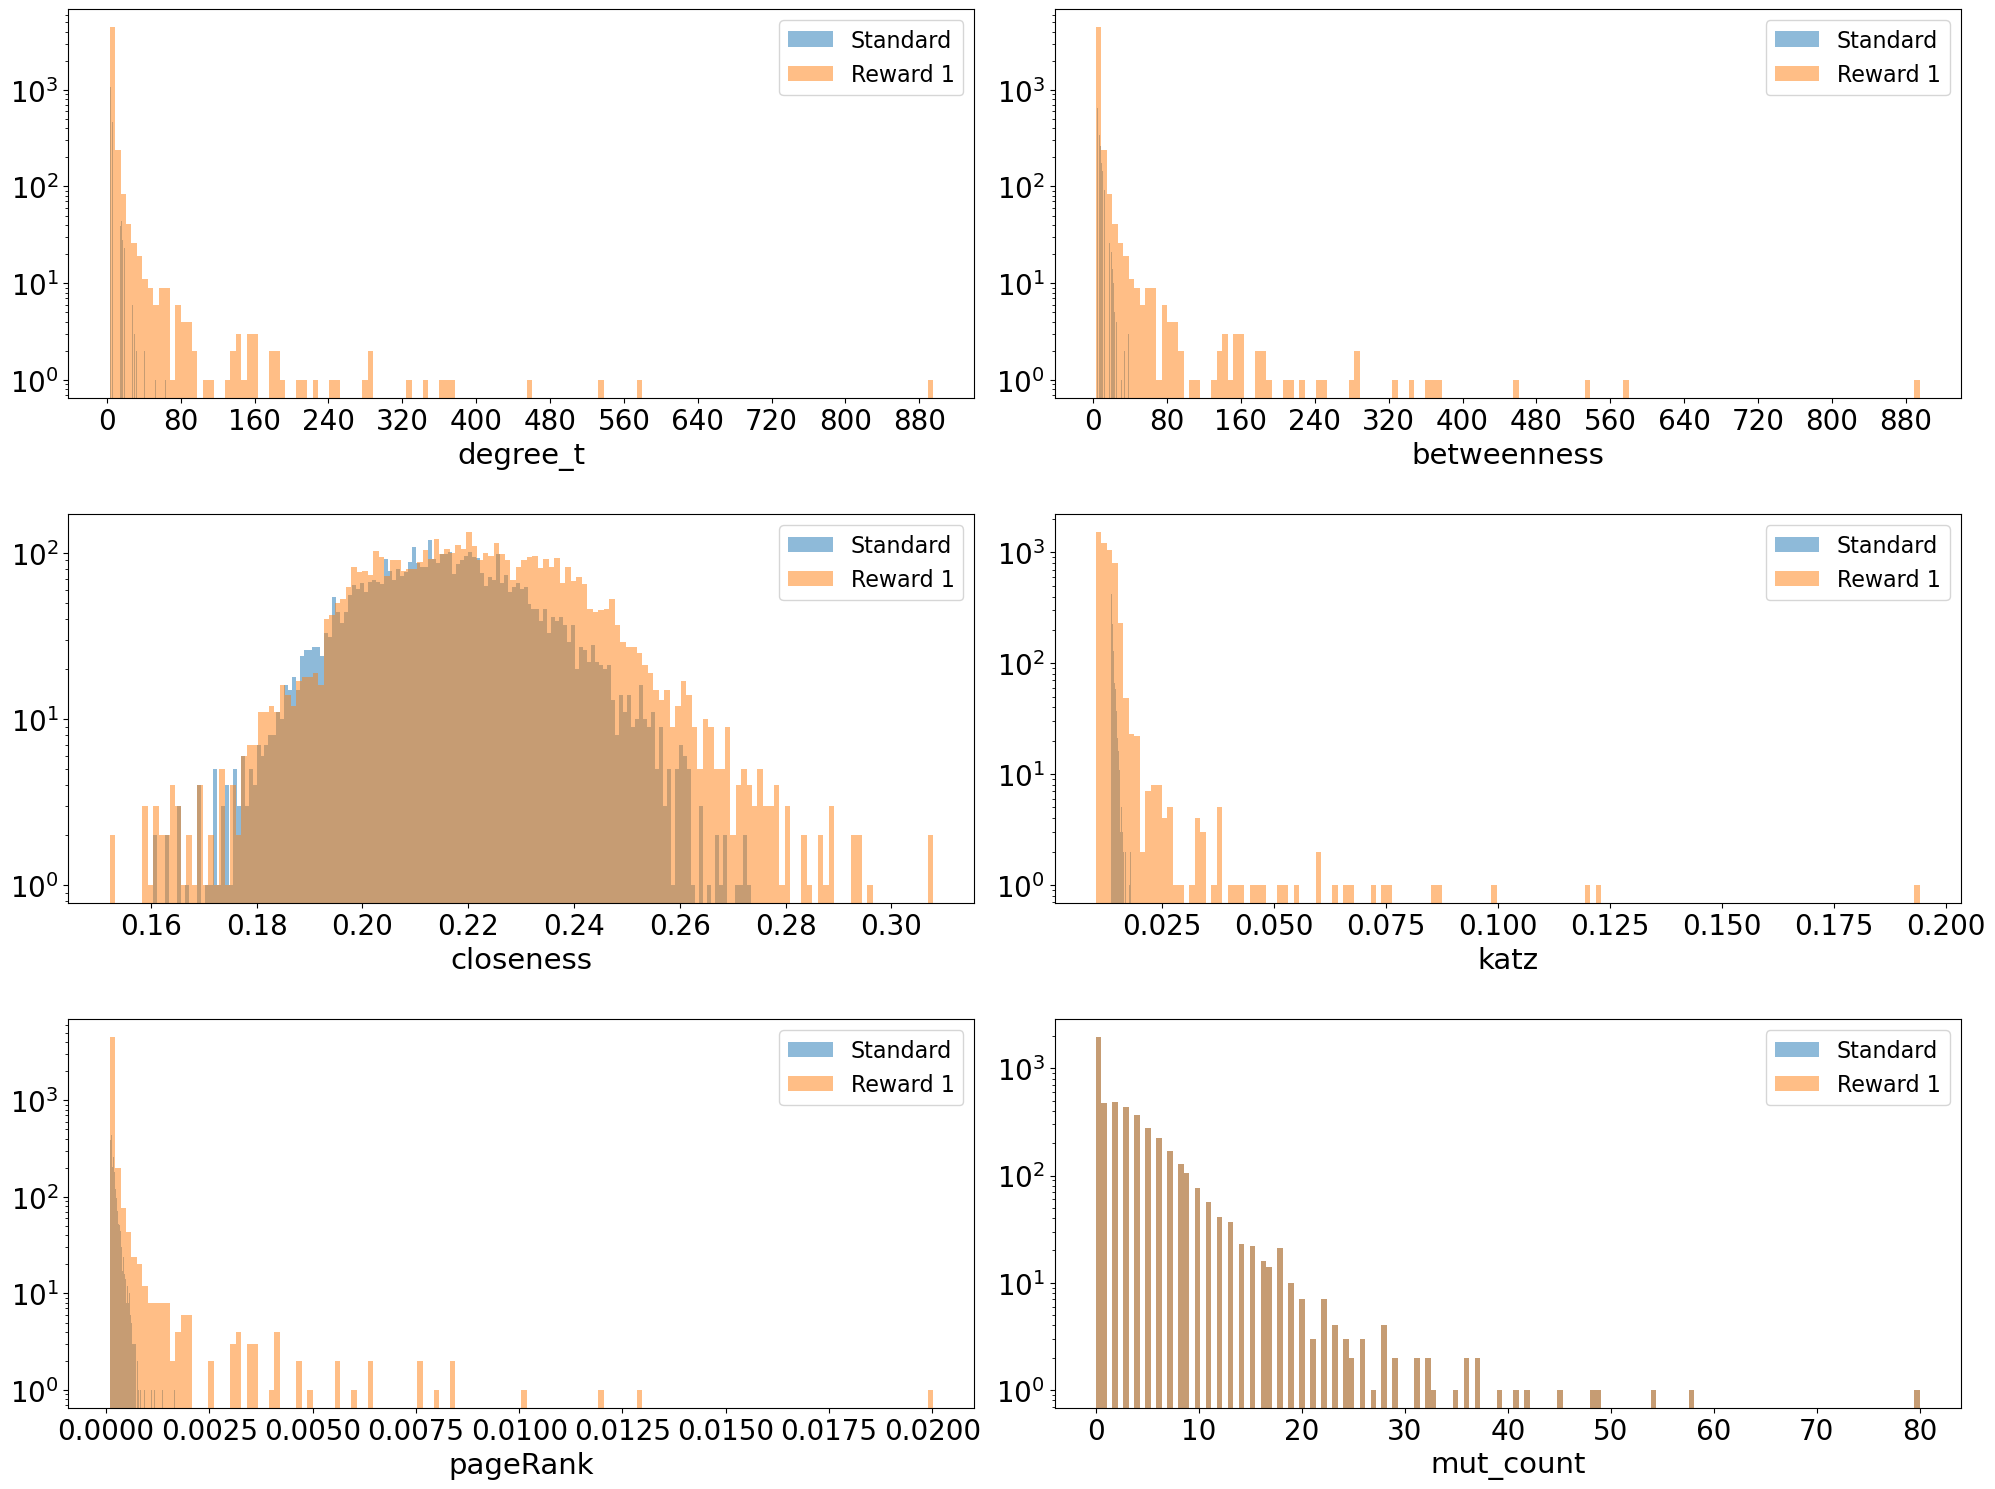

In [21]:
if 1:
    comp_std_net: NetworkComp = NetworkComp(healthy, 5, "standard_5K_6TF_hsbm", "norm3_5K_6TF_hsbm", mod_type="sbm")

    fig, graph_stats_std, graph_stats_rwd = comp_std_net.plot_network_stats(
        nodes_df_1=std_nodes_df, nodes_df_2=rwd_1_nodes_df, label_1="Standard", label_2="Reward 1"
    )

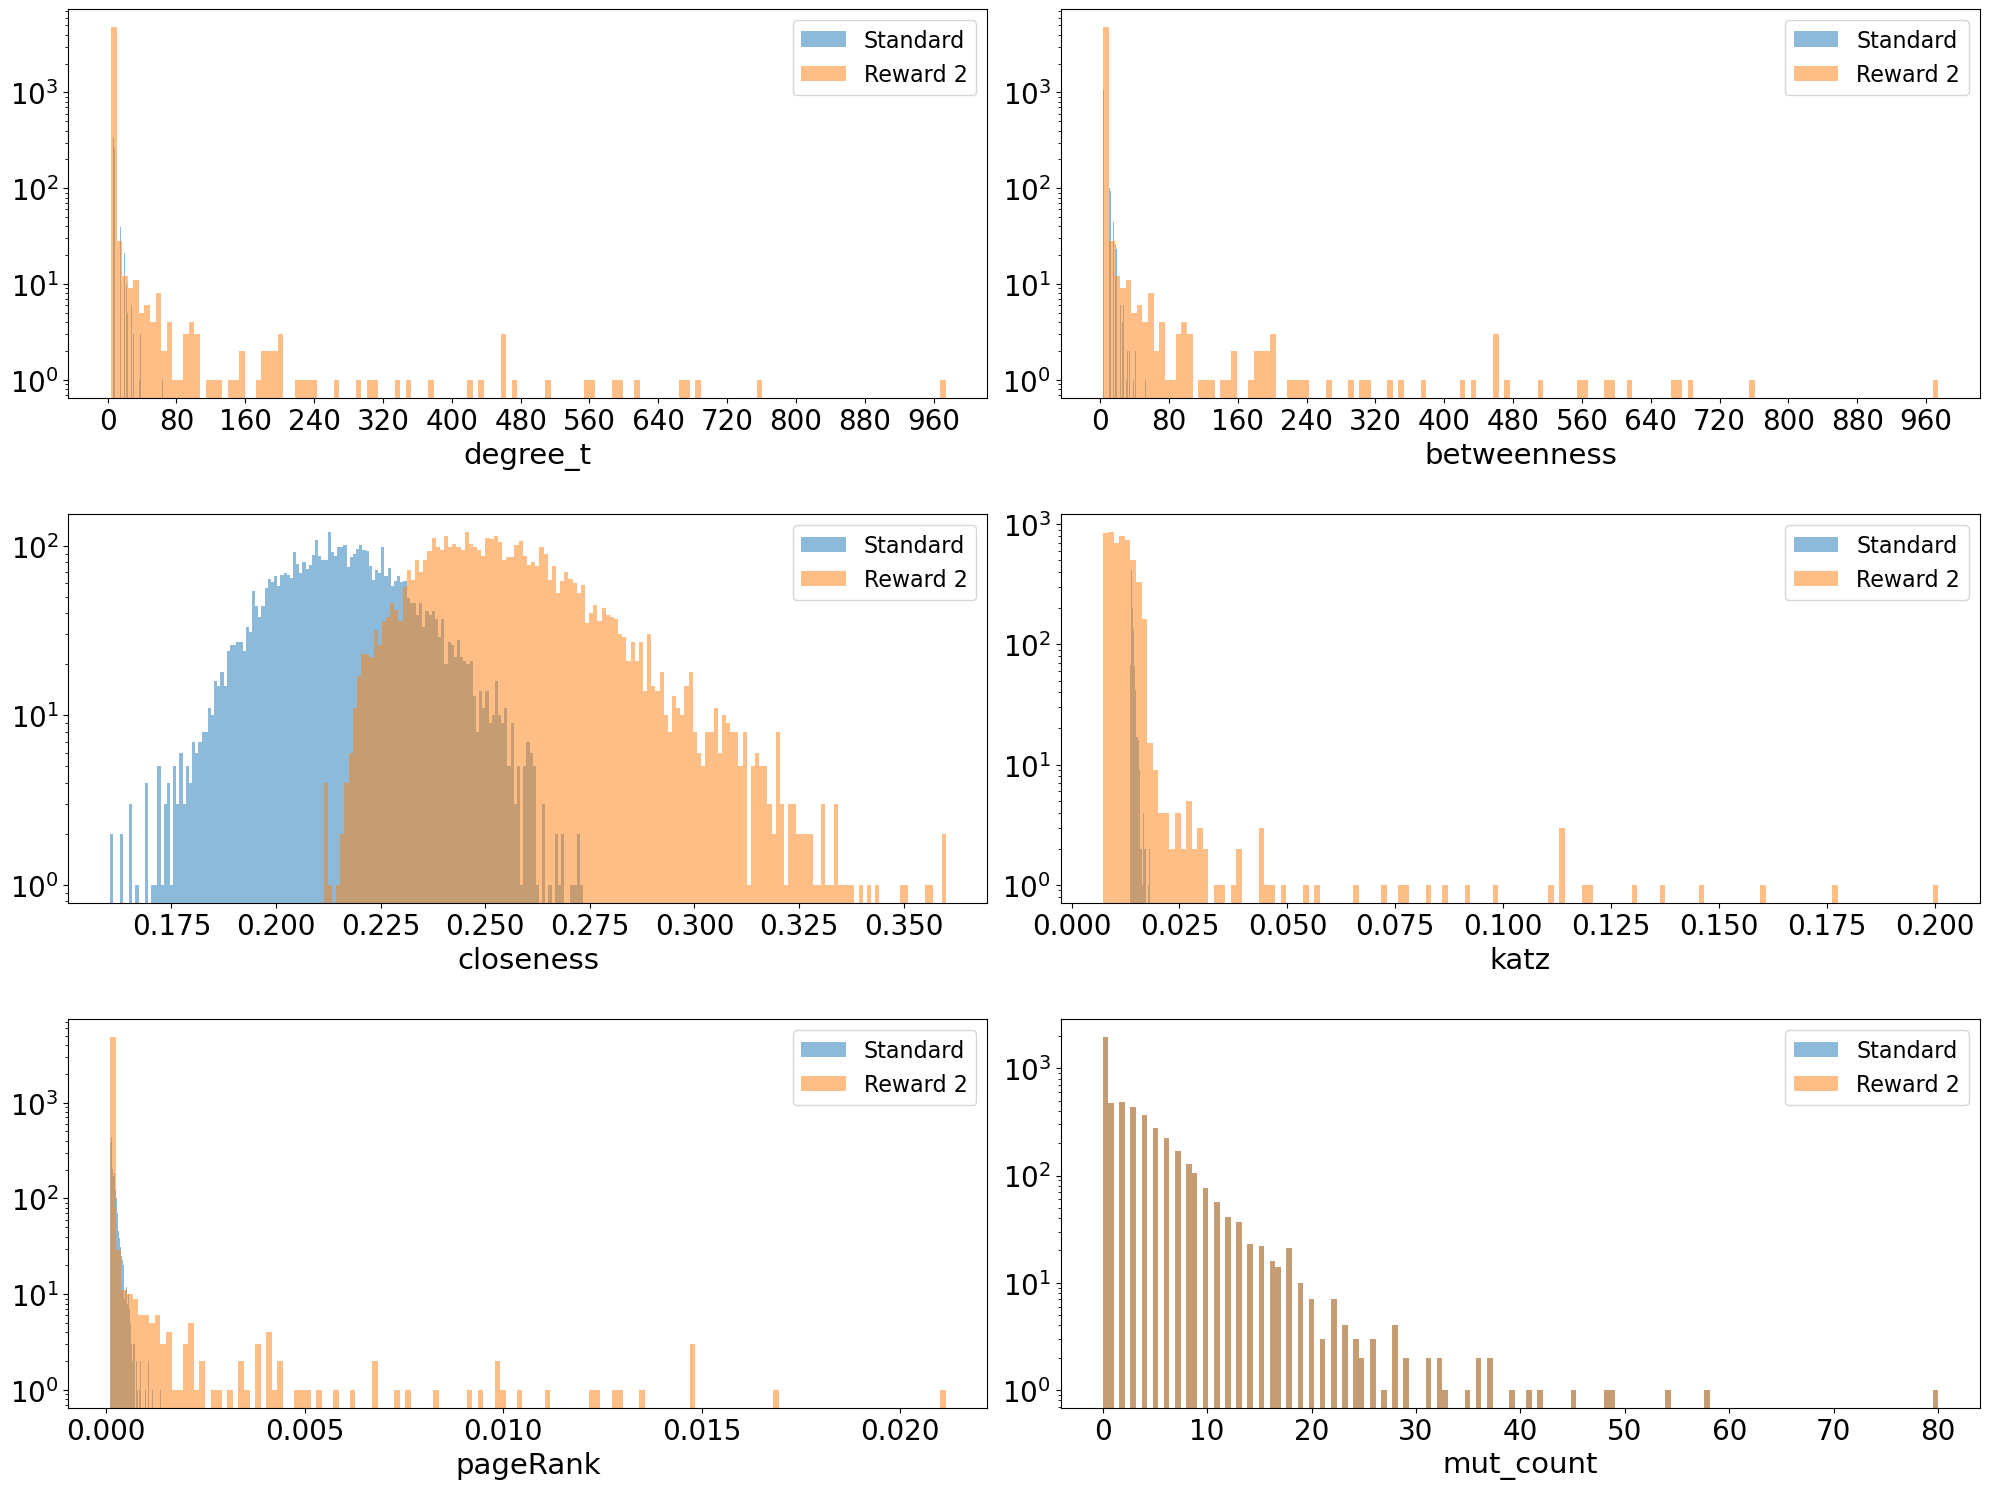

In [22]:
if 1:
    comp_std_net: NetworkComp = NetworkComp(healthy, 5, "standard_5K_6TF_hsbm", "sigmoid_5K_6TF_hsbm", mod_type="sbm")

    fig, graph_stats_std, graph_stats_rwd = comp_std_net.plot_network_stats(
        nodes_df_1=std_nodes_df, nodes_df_2=rwd_2_nodes_df, label_1="Standard", label_2="Reward 2"
    )